In [7]:
!pip install matplotlib


  Using cached contourpy-1.2.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.1/159.1 kB 5.9 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.5-cp310-cp310-macosx_11_0_arm64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.1.1-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 4.0 MB/s eta 0:00:0000:0100:01m
Using cached contourpy-1.2.0-cp310-cp310-macosx_11_0_arm64.whl (242 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 4.0 MB/s eta 0:00:0000:0100:01
Using cached kiwisolver-1.4.5-cp310-cp310-macosx_11_0_arm64.whl (66 kB)
Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)


In [8]:
import pandas as pd
import numpy as np
import requests
from PIL import Image, ImageEnhance
from io import BytesIO
import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string


In [20]:
df = pd.read_csv("A2_Data.csv")
df.head()
df = df.dropna()
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nalishjain/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nalishjain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nalishjain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
image_text_dict = {}
count = 0
for index, row in df.iterrows():
    urls = row['Image']
    url_list = json.loads(urls.replace("'", "\""))
    text = row['Review Text']
    for url in url_list:
        image_text_dict[count] = (url,text)
        count += 1


In [24]:

def preprocess_image(img_url, factor = 2):
    # Make an HTTP request to the specified image URL and get the response
    response = requests.get(img_url)
    
    # Open the image using the PIL (Python Imaging Library) from the response content

    img = Image.open(BytesIO(response.content))

    img = img.resize((224, 224)) #Resizing
    
    enhancer = ImageEnhance.Brightness(img) #increasing brightness
    img = enhancer.enhance(factor)

    datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True) #random flips


    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array =  datagen.flow(img_array).next()
    img_array = preprocess_input(img_array)
    
    return img_array

def extract_image_features(model, img_array):
    features = model.predict(img_array)
    features = features.flatten()
    return features

def preprocess_text(text):
    text = text.lower()

    tokens = word_tokenize(text)

    # Removing punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    # Stop word removal
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Rejoin the tokens to form the preprocessed text
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

In [22]:

invalid_url_ids = []
for i in range(len(image_text_dict)):
    try:
        Image.open(BytesIO(requests.get(image_text_dict[i][0]).content))
    except:
        invalid_url_ids.append(i)
image_text_dict = {key: value for key, value in image_text_dict.items() if key not in invalid_url_ids}
print(len(image_text_dict))

1639


In [ ]:
base_model = VGG16(weights='imagenet')
image_model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)
print(image_model.summary())


In [ ]:
# Apply image feature extraction to each image in the dataset
url_ids = list(image_text_dict.keys())
img_features = []
for url_id in url_ids:
    img_array = preprocess_image(image_text_dict[url_id][0])
    img_feature = extract_image_features(image_model, img_array)
    img_features.append(img_feature)

img_features = normalize(np.array(img_features), norm='l2', axis=1)

img_features_dict = {}

count = 0
for url_id in url_ids:
    img_features_dict[url_id] = img_features[count]
    count +=1

with open('img_features_dict.pkl', 'wb') as f:
    pickle.dump(img_features_dict, f)

In [41]:
url_ids = list(image_text_dict.keys())
text_reviews = {}
for url_id in url_ids:
    pp_text = preprocess_text(image_text_dict[url_id][1])
    text_reviews[url_id] = pp_text
# print(text_reviews)

tf = {}
idf = {}
tf_idf = {}

for url_id in text_reviews.keys():
    # calculating idf
    word_list = text_reviews[url_id].split()

    tf[url_id] = {}
    for word in set(word_list):
        if word not in idf:
            idf[word] = 1
        else:
            idf[word] += 1

    # calculating tf
    for word in word_list:
        if word not in tf[url_id]:
            tf[url_id][word] = 1 
        else:
            tf[url_id][word] += 1             

for url_id in text_reviews.keys():
    word_list = text_reviews[url_id].split()
    tf_idf[url_id] = {}

    for word in set(word_list): 
        tf_idf[url_id][word] = np.log(len(image_text_dict)/idf[word])*tf[url_id][word]         

    

with open('tf_idf.pkl', 'wb') as f:
    pickle.dump(tf_idf, f)


(1, 224, 224, 3)
(1, 224, 224, 3)


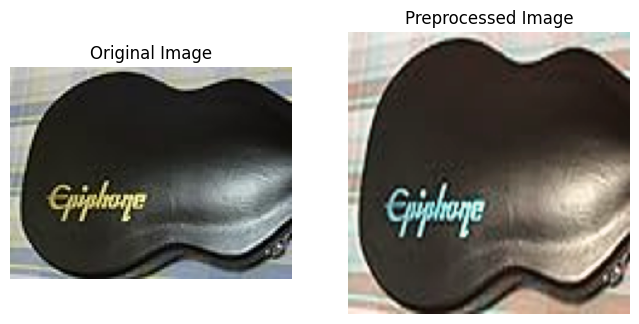

In [54]:
example_img_url = image_text_dict[70][0]
preprocessed_img_array = preprocess_image(example_img_url, factor = 1.2)
print(preprocessed_img_array.shape)
# Convert the preprocessed image array back to a PIL Image for visualization
preprocessed_img = image.array_to_img(preprocessed_img_array[0])

# Display the original and preprocessed images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(Image.open(BytesIO(requests.get(example_img_url).content)))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Preprocessed Image")
plt.imshow(preprocessed_img)
plt.axis("off")
plt.show()